# pyWavelet Snow Radar Processor

In [1]:
#pyWavelet mods
import picklayers
import calcpulse
import snowradar

#Community packages
import os
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time

C:\Users\kingj\AppData\Local\Continuum\anaconda3\envs\wavelet\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
density_snow = 0.300 #Density of snow on sea ice; See Alexandrov et al., 2010, The Cryosphere
perm_snow = (1 + 0.51 * density_snow) ** 3  #Density to permitivity
n_snow = np.sqrt(perm_snow) #Permitivity to refractive index
c = 299792458 #Vacuum speed of light

In [3]:
radar_file = "./data/sr/Data_20160419_04_010.mat"
radar_dat = snowradar.OIB(radar_file, l_case='full')

In [4]:
radar_dat.extent

array([-86.76363202,  80.22643933, -86.76076421,  80.27112907])

Convert the radar's GPS time to UTC and account for leap seconds

In [5]:
example_date = datetime.datetime.utcfromtimestamp(radar_dat.time_utc[0])
print(example_date)

2016-04-19 13:06:23.961526


### Signals stuff

In [13]:
oversample_num = 1000
num_nyquist_ts = 100
nyquist_sf = 2*radar_dat.bandwidth
fs = nyquist_sf *oversample_num 
time_step = 1/fs 
max_time  = num_nyquist_ts*oversample_num*time_step
time_vect = np.arange(-max_time,max_time,time_step)

In [6]:
radar_dat.calcpulsewidth()
print(radar_dat.epw)
print(radar_dat.n2n)

0.07570516616161617
0.20186025505333335


### This applies the picklayer function to every trace
TODO: Multi thread and bake into snowradar class

In [19]:
l_as,l_si = np.apply_along_axis(picklayers.picklayers, 0, radar_dat.data,radar_dat.n2n,radar_dat.dfr,n_snow)

Mean snow depth (m): 0.28251865766498313


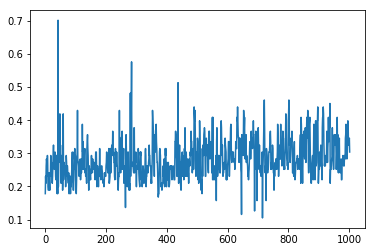

In [20]:
snow_depth = (l_si - l_as) * radar_dat.dfr / n_snow
print("Mean snow depth (m):", np.mean(snow_depth))
plt.plot(snow_depth);

# So niceeeeeeeeeeeeee

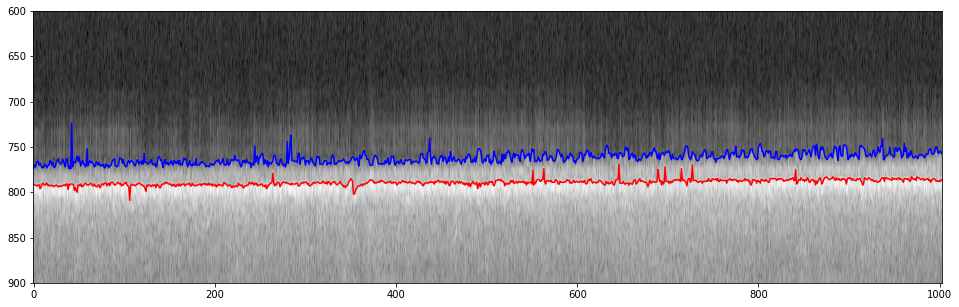

In [21]:
fig, ax = plt.subplots(figsize=(25,5))
ax.imshow(10 * np.log10(radar_dat.data), interpolation='nearest', cmap="gist_gray")
ax.plot(l_si, color='r')
ax.plot(l_as, color='b')
ax.set_ylim([900, 600])
plt.show()